### Generating mnist type of images using DCGAN : https://arxiv.org/pdf/1511.06434.pdf

### step 1 : Data Extraction 

In [1]:
# utils 

def get_number_params(model): 
    nb = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return nb


def display_grid(batch): 
    print("Batch shape : ", batch.shape)
    grid = torchvision.utils.make_grid(batch)
    plt.imshow(grid.permute(1, 2, 0))
    plt.show()

In [2]:
import os 

CURR_PATH = os.getcwd()
DATA_PATH = os.path.split(os.path.split(CURR_PATH)[0])[0]
DIR_PATH = os.path.join(DATA_PATH, "data/MNIST/trainingSample")

In [1]:
# hyper params 

image_size = 64
batch_size = 128
epochs = 20

lr = 0.0002
beta = 0.5
slope = 0.2

d_noise = 100

# init 
# TODO : Add init generator
std_init = 0.2

In [4]:
import torchvision 
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(image_size), 
    torchvision.transforms.CenterCrop(image_size), 
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

data_loader = torchvision.datasets.ImageFolder(
    DIR_PATH, 
    transform=transform
)

data = torch.utils.data.DataLoader(
    data_loader, 
    batch_size=batch_size, 
    shuffle=True
)

print(f"Found : {len(data_loader)} datapoints")

Found : 41715 datapoints


In [5]:
import matplotlib.pyplot as plt 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([128, 3, 64, 64])


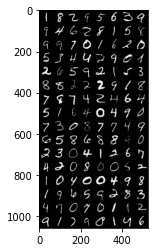

In [6]:
batch = iter(data).next()[0]

print("Batch shape : ", batch.shape)
grid = torchvision.utils.make_grid(batch)
plt.imshow(grid.permute(1, 2, 0))

### Generator model 

In [7]:
class Generator(torch.nn.Module): 
    def __init__(self): 
        super(Generator, self).__init__()
        
        modules = [
            torch.nn.ConvTranspose2d(100, 512, 4, stride=1, padding=0, bias=False), 
            torch.nn.BatchNorm2d(512), 
            torch.nn.ReLU(inplace=True), 
            torch.nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1, bias=False), 
            torch.nn.BatchNorm2d(256), 
            torch.nn.ReLU(inplace=True), 
            torch.nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False), 
            torch.nn.BatchNorm2d(128), 
            torch.nn.ReLU(inplace=True), 
            torch.nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False), 
            torch.nn.BatchNorm2d(64), 
            torch.nn.ReLU(inplace=True), 
            torch.nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False), 
            torch.nn.Tanh(), 
        ]
        
        self.seq_modules = torch.nn.Sequential(*modules)
        
    def forward(self, x): 
        result = self.seq_modules(x) 
        return result
    
    
    
class Discriminator(torch.nn.Module): 
    def __init__(self): 
        super(Discriminator, self).__init__()
        
        modules = [
            torch.nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False), 
            torch.nn.BatchNorm2d(64), 
            torch.nn.LeakyReLU(slope, inplace=True), 
            torch.nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False), 
            torch.nn.BatchNorm2d(128), 
            torch.nn.LeakyReLU(slope, inplace=True), 
            torch.nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False), 
            torch.nn.BatchNorm2d(256), 
            torch.nn.LeakyReLU(slope, inplace=True),
            torch.nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False), 
            torch.nn.BatchNorm2d(512), 
            torch.nn.LeakyReLU(slope, inplace=True), 
            torch.nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False), 
            torch.nn.Sigmoid(), 
        ]
        
        self.seq_modules = torch.nn.Sequential(*modules)
        
    def forward(self, x): 
        result = self.seq_modules(x) 
        return result

In [8]:
g_net = Generator().to(device)
print("trainable params : ", get_number_params(g_net))

trainable params :  3576704


In [9]:
d_net = Discriminator().to(device)
print("trainable params : ", get_number_params(d_net))

trainable params :  2765696


### optimizers and losses

In [10]:
g_optim = torch.optim.Adam(g_net.parameters(), lr, betas=(beta, 0.99))
d_optim = torch.optim.Adam(d_net.parameters(), lr, betas=(beta, 0.99))
bce_criterion = torch.nn.BCELoss().to(device)

#### training loop 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


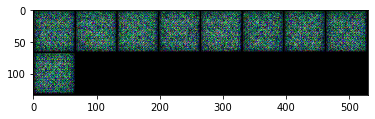

epoch :  0
G loss :  tensor(2.5454, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(1.4691, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


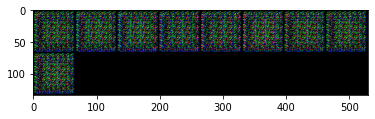

epoch :  0
G loss :  tensor(7.8222, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0075, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


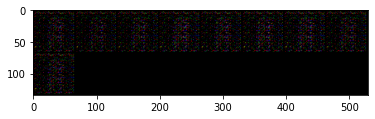

epoch :  0
G loss :  tensor(8.3335, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0025, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


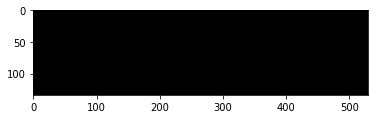

epoch :  0
G loss :  tensor(8.9409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0011, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


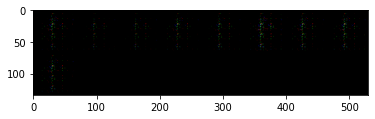

epoch :  0
G loss :  tensor(4.7732, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.3797, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


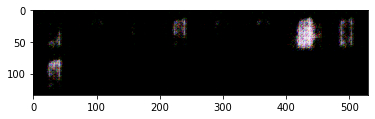

epoch :  0
G loss :  tensor(2.9338, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1894, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


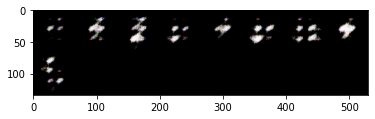

epoch :  0
G loss :  tensor(4.6883, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1858, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


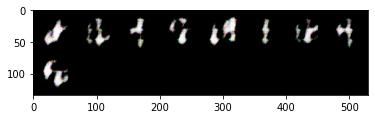

epoch :  1
G loss :  tensor(5.6294, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.3765, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


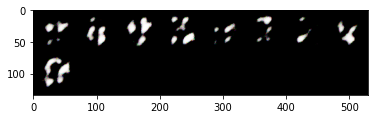

epoch :  1
G loss :  tensor(1.3095, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.4196, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


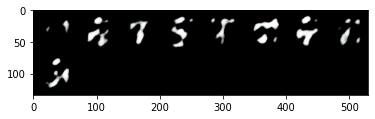

epoch :  1
G loss :  tensor(2.9551, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.5581, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


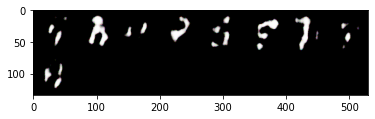

epoch :  1
G loss :  tensor(3.0556, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.6745, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


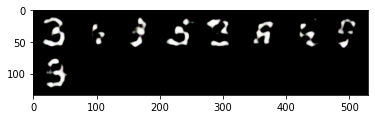

epoch :  1
G loss :  tensor(3.1305, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.3961, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


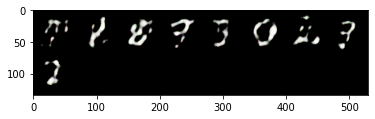

epoch :  1
G loss :  tensor(4.8111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(1.4277, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


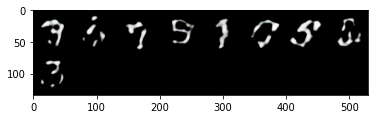

epoch :  1
G loss :  tensor(3.0932, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.7813, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


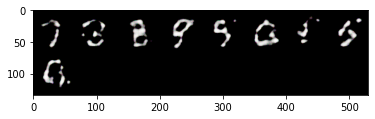

epoch :  2
G loss :  tensor(2.1691, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.3676, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


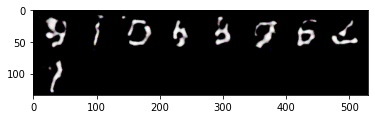

epoch :  2
G loss :  tensor(0.7561, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(1.5757, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


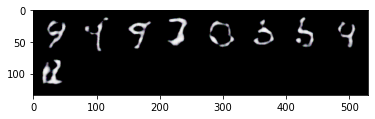

epoch :  2
G loss :  tensor(0.0505, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.9676, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


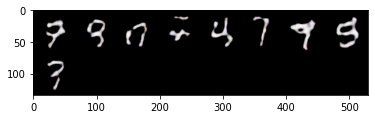

epoch :  2
G loss :  tensor(4.1495, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0713, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


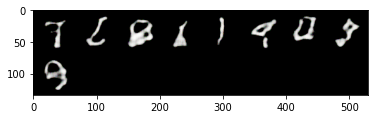

epoch :  2
G loss :  tensor(1.5743, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.6190, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


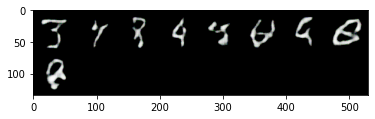

epoch :  2
G loss :  tensor(2.6564, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.6161, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


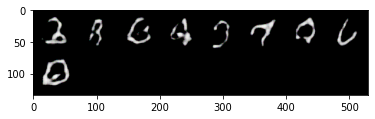

epoch :  2
G loss :  tensor(2.6453, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.2493, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


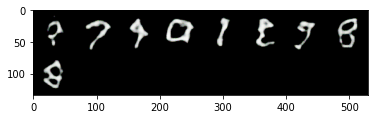

epoch :  3
G loss :  tensor(3.4092, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0997, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


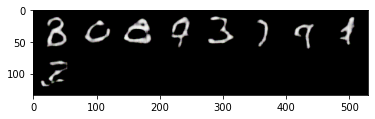

epoch :  3
G loss :  tensor(2.0903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(2.4799, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


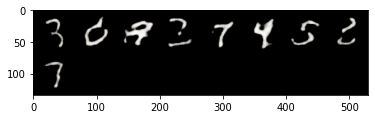

epoch :  3
G loss :  tensor(3.8524, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1025, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


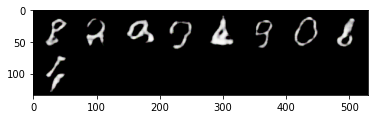

epoch :  3
G loss :  tensor(0.7327, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.4009, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


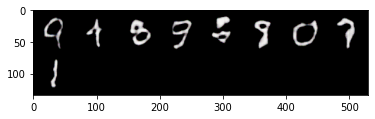

epoch :  3
G loss :  tensor(4.5376, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0299, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


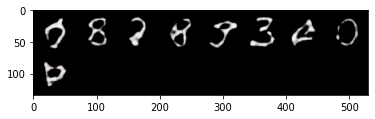

epoch :  3
G loss :  tensor(1.4058, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.7292, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


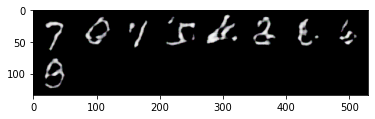

epoch :  3
G loss :  tensor(2.6583, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.3212, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


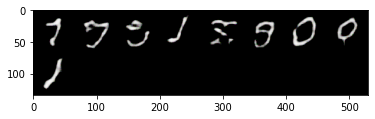

epoch :  4
G loss :  tensor(0.9778, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.4518, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


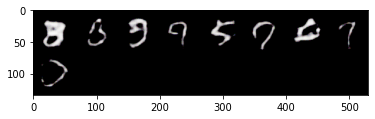

epoch :  4
G loss :  tensor(4.0252, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0505, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


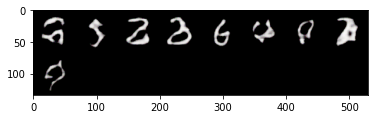

epoch :  4
G loss :  tensor(5.6903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0107, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


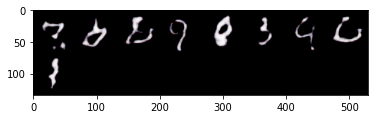

epoch :  4
G loss :  tensor(1.8012, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.8529, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


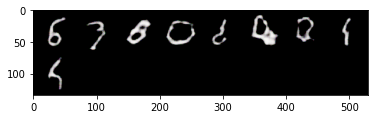

epoch :  4
G loss :  tensor(1.9341, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.3035, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


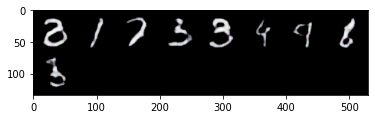

epoch :  4
G loss :  tensor(2.0187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.5562, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


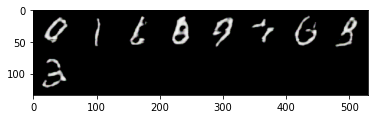

epoch :  4
G loss :  tensor(12.8892, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.4002, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


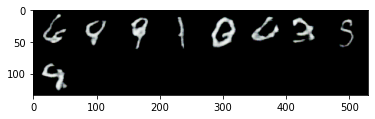

epoch :  5
G loss :  tensor(2.4300, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.3830, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


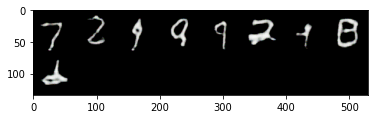

epoch :  5
G loss :  tensor(1.1700, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.7113, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


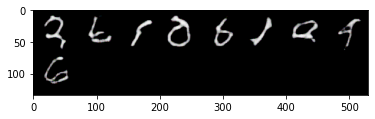

epoch :  5
G loss :  tensor(4.2852, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


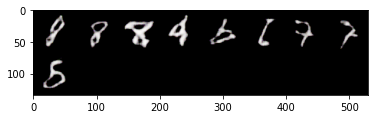

epoch :  5
G loss :  tensor(2.2444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.4810, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


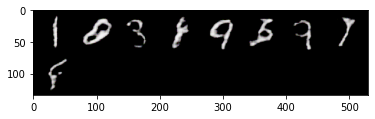

epoch :  5
G loss :  tensor(2.8536, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.4301, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


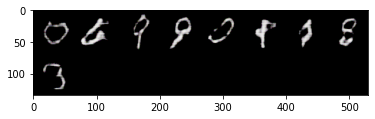

epoch :  5
G loss :  tensor(3.9369, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1521, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


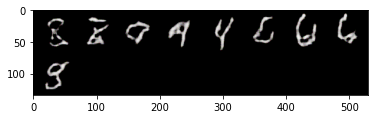

epoch :  5
G loss :  tensor(4.3528, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0363, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


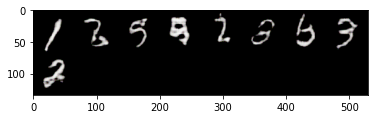

epoch :  6
G loss :  tensor(4.8884, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0252, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


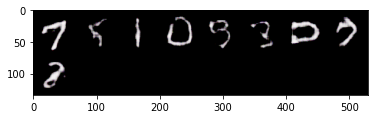

epoch :  6
G loss :  tensor(2.6468, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.5638, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


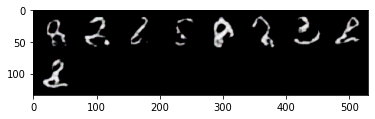

epoch :  6
G loss :  tensor(3.2536, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.3181, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


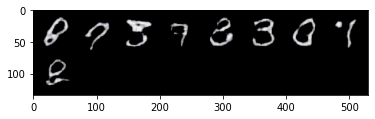

epoch :  6
G loss :  tensor(4.1287, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0384, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


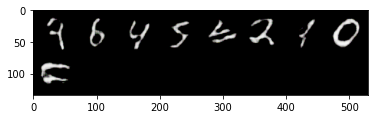

epoch :  6
G loss :  tensor(2.0550, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.4461, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


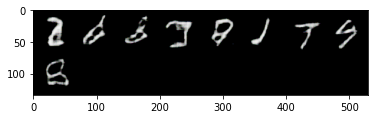

epoch :  6
G loss :  tensor(3.9626, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0550, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


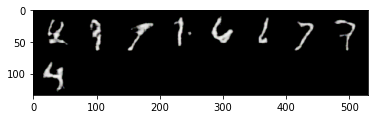

epoch :  6
G loss :  tensor(4.8785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0828, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


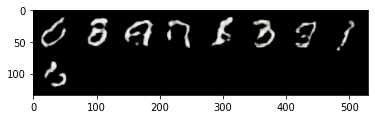

epoch :  7
G loss :  tensor(2.1931, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.5205, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


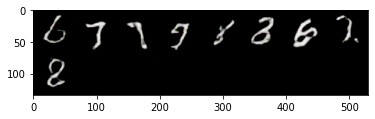

epoch :  7
G loss :  tensor(3.9629, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0523, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


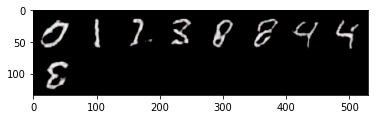

epoch :  7
G loss :  tensor(5.0720, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0170, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


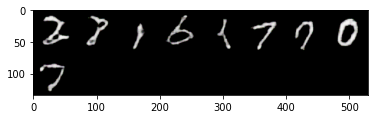

epoch :  7
G loss :  tensor(4.1371, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0882, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


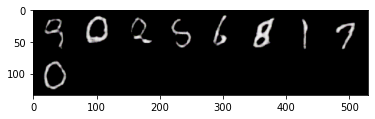

epoch :  7
G loss :  tensor(2.5708, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.3329, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


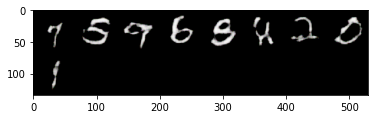

epoch :  7
G loss :  tensor(2.8115, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.3669, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


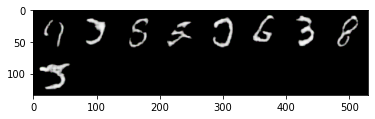

epoch :  7
G loss :  tensor(6.9536, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(10.6387, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


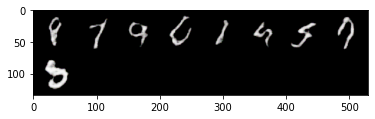

epoch :  8
G loss :  tensor(3.1216, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.3045, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


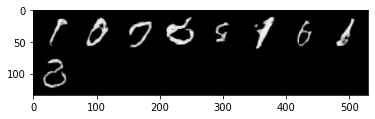

epoch :  8
G loss :  tensor(4.6275, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0559, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


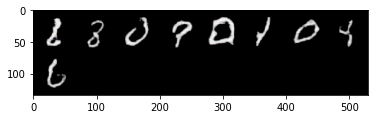

epoch :  8
G loss :  tensor(4.9786, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0317, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


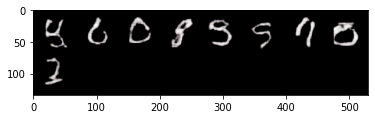

epoch :  8
G loss :  tensor(1.5538, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.7747, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


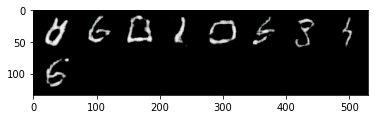

epoch :  8
G loss :  tensor(4.3186, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.6883, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


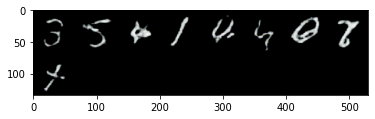

epoch :  8
G loss :  tensor(3.3785, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1613, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


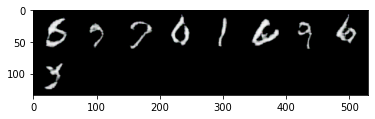

epoch :  8
G loss :  tensor(16.8278, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.3782, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


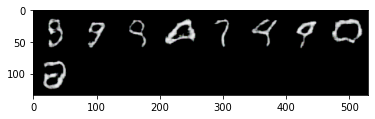

epoch :  9
G loss :  tensor(2.8465, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.3190, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


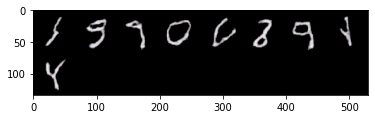

epoch :  9
G loss :  tensor(4.5569, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0484, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


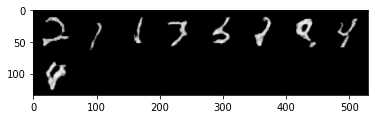

epoch :  9
G loss :  tensor(2.8033, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.2487, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


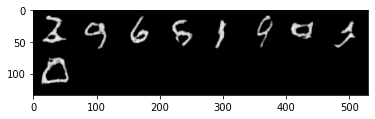

epoch :  9
G loss :  tensor(2.6018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1490, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


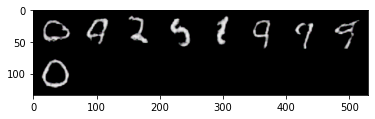

epoch :  9
G loss :  tensor(6.0959, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0255, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


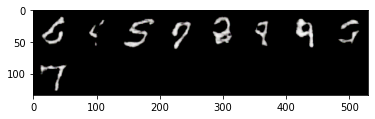

epoch :  9
G loss :  tensor(1.7124, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.9732, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


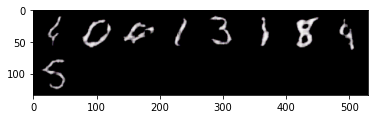

epoch :  9
G loss :  tensor(4.2696, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(1.1166, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


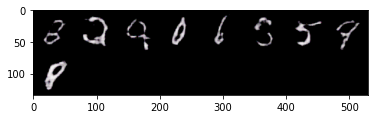

epoch :  10
G loss :  tensor(5.0858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(1.0398, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


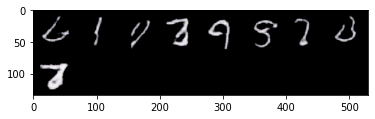

epoch :  10
G loss :  tensor(3.6301, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.2543, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


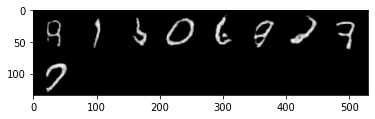

epoch :  10
G loss :  tensor(2.9319, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.4869, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


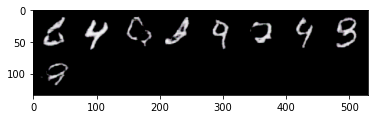

epoch :  10
G loss :  tensor(6.5466, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(7.2811, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


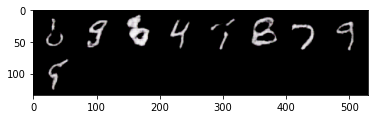

epoch :  10
G loss :  tensor(0.0531, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.9951, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


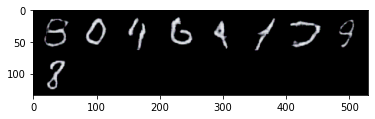

epoch :  10
G loss :  tensor(3.2455, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(1.8037, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


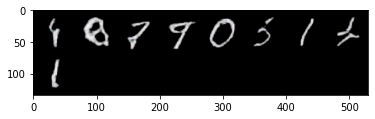

epoch :  10
G loss :  tensor(3.7632, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0474, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


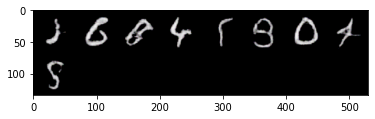

epoch :  11
G loss :  tensor(1.7767, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1234, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


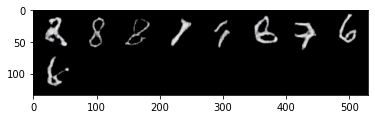

epoch :  11
G loss :  tensor(4.6933, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0441, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


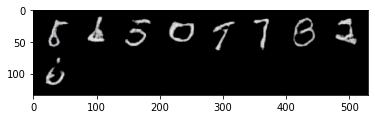

epoch :  11
G loss :  tensor(4.8790, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0234, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


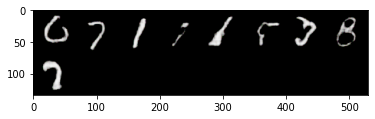

epoch :  11
G loss :  tensor(1.7272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.6519, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


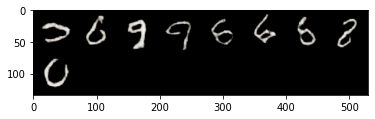

epoch :  11
G loss :  tensor(2.5296, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.3833, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


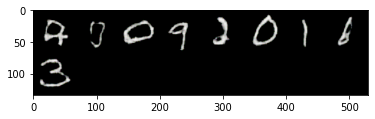

epoch :  11
G loss :  tensor(3.6052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.4241, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


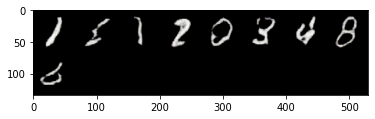

epoch :  11
G loss :  tensor(4.0015, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0646, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


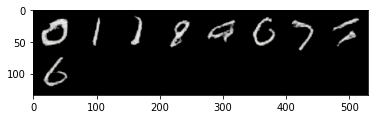

epoch :  12
G loss :  tensor(4.8486, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1145, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


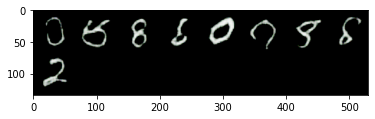

epoch :  12
G loss :  tensor(1.7901, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.6666, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


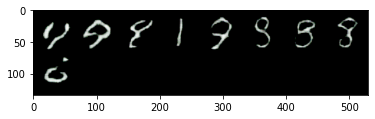

epoch :  12
G loss :  tensor(2.5265, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.9145, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


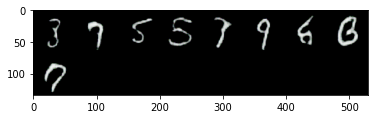

epoch :  12
G loss :  tensor(0.6507, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(3.3218, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


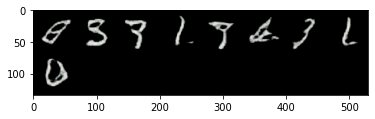

epoch :  12
G loss :  tensor(4.4104, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0787, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


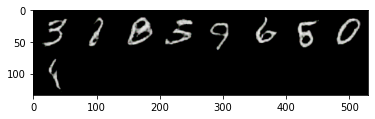

epoch :  12
G loss :  tensor(1.3429, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(1.4958, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


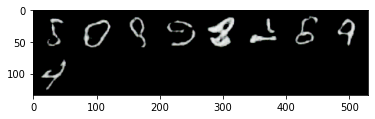

epoch :  12
G loss :  tensor(3.6181, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(4.7616, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


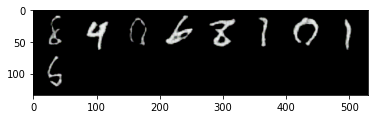

epoch :  13
G loss :  tensor(3.3756, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1491, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


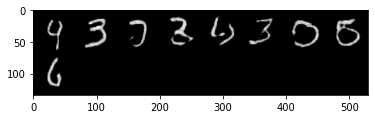

epoch :  13
G loss :  tensor(3.4044, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1578, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


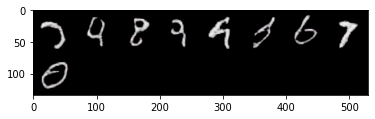

epoch :  13
G loss :  tensor(5.2924, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0165, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


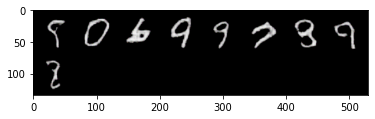

epoch :  13
G loss :  tensor(4.4175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0342, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


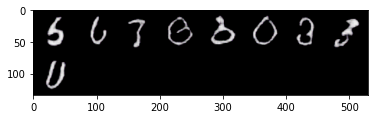

epoch :  13
G loss :  tensor(0.5648, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(1.6662, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


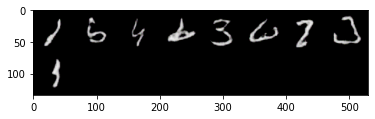

epoch :  13
G loss :  tensor(1.9724, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1882, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


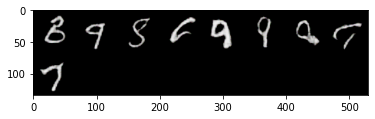

epoch :  13
G loss :  tensor(0.4907, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(1.3131, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


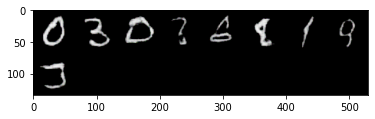

epoch :  14
G loss :  tensor(3.0469, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.2428, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


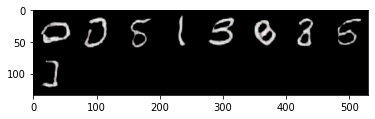

epoch :  14
G loss :  tensor(0.8978, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.9609, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


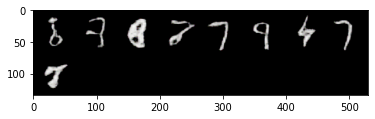

epoch :  14
G loss :  tensor(5.2742, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.5336, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


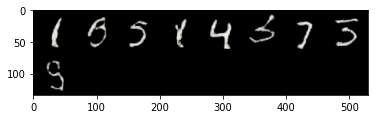

epoch :  14
G loss :  tensor(3.1361, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.3286, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


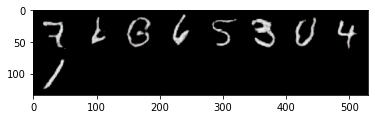

epoch :  14
G loss :  tensor(5.1380, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0251, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


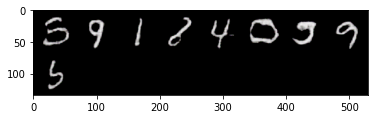

epoch :  14
G loss :  tensor(4.8687, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0247, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


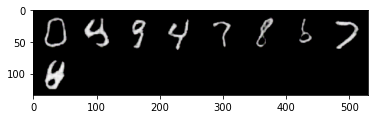

epoch :  14
G loss :  tensor(2.8059, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.2438, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


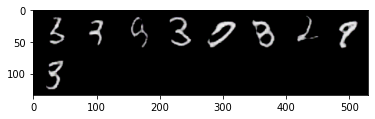

epoch :  15
G loss :  tensor(3.8461, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0866, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


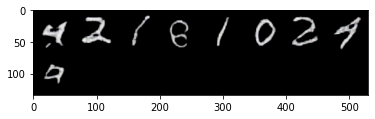

epoch :  15
G loss :  tensor(3.3068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1809, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


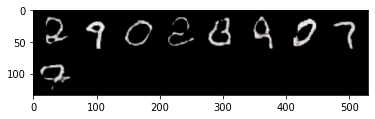

epoch :  15
G loss :  tensor(4.2276, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0417, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


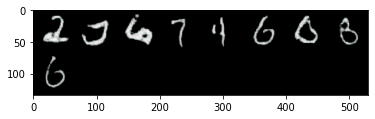

epoch :  15
G loss :  tensor(0.5692, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(1.7278, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


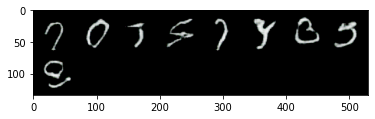

epoch :  15
G loss :  tensor(4.1093, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(1.0039, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


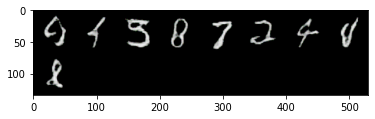

epoch :  15
G loss :  tensor(4.0219, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1583, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


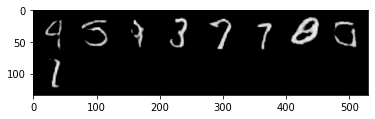

epoch :  15
G loss :  tensor(3.2482, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.2260, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


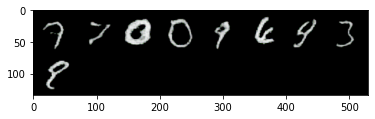

epoch :  16
G loss :  tensor(4.7159, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0790, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


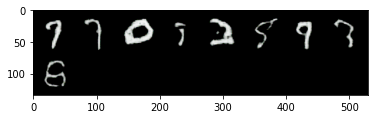

epoch :  16
G loss :  tensor(5.2385, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0228, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


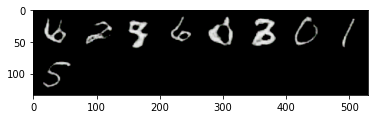

epoch :  16
G loss :  tensor(2.3834, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.3129, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


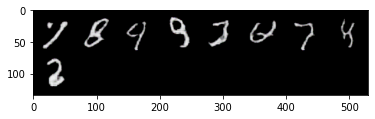

epoch :  16
G loss :  tensor(4.5873, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0291, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


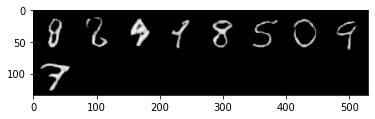

epoch :  16
G loss :  tensor(1.5620, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.7479, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


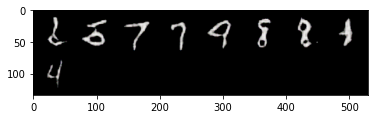

epoch :  16
G loss :  tensor(3.7175, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.4610, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


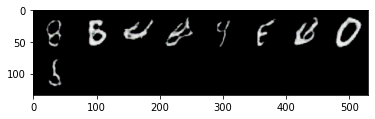

epoch :  16
G loss :  tensor(1.8521, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.8447, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


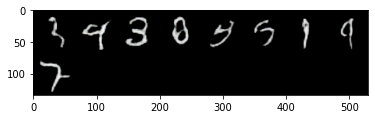

epoch :  17
G loss :  tensor(4.8051, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(1.0157, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


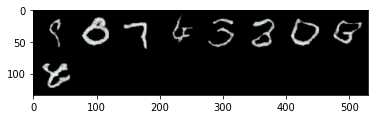

epoch :  17
G loss :  tensor(3.6094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1286, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


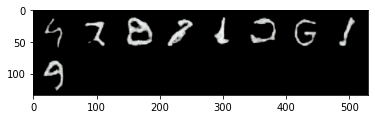

epoch :  17
G loss :  tensor(1.8764, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.6853, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


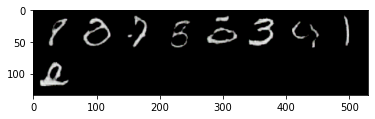

epoch :  17
G loss :  tensor(3.6730, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1089, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


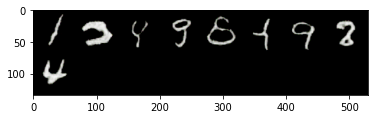

epoch :  17
G loss :  tensor(2.2337, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.5802, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


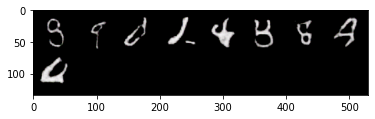

epoch :  17
G loss :  tensor(2.5744, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.2139, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


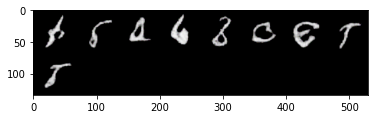

epoch :  17
G loss :  tensor(4.9699, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0310, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


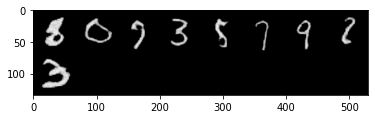

epoch :  18
G loss :  tensor(5.5724, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0157, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


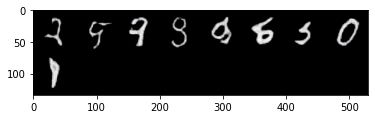

epoch :  18
G loss :  tensor(1.2791, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(1.0174, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


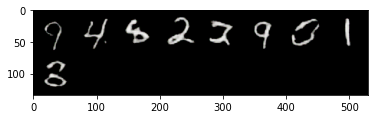

epoch :  18
G loss :  tensor(2.2462, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.2634, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


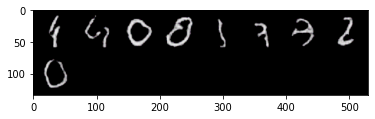

epoch :  18
G loss :  tensor(4.9616, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0325, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


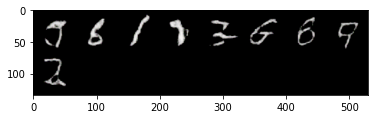

epoch :  18
G loss :  tensor(3.3975, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1435, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


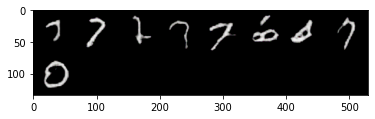

epoch :  18
G loss :  tensor(5.0829, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0239, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


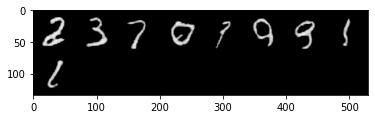

epoch :  18
G loss :  tensor(6.5654, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0101, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


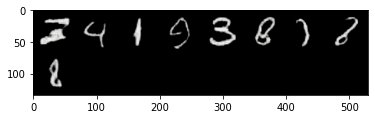

epoch :  19
G loss :  tensor(5.8415, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.0143, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


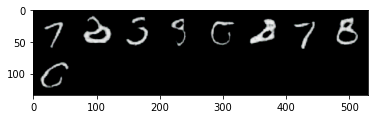

epoch :  19
G loss :  tensor(1.1108, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.9994, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


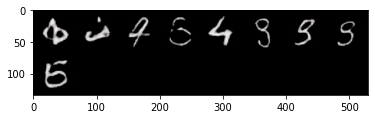

epoch :  19
G loss :  tensor(2.1822, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.3080, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


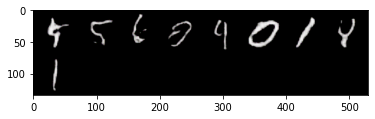

epoch :  19
G loss :  tensor(4.1793, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1683, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


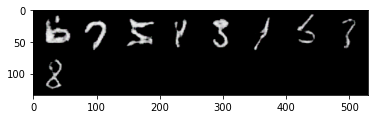

epoch :  19
G loss :  tensor(2.3957, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.6592, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


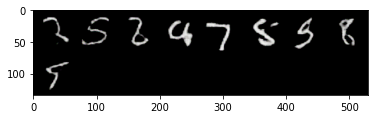

epoch :  19
G loss :  tensor(5.1114, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.1131, device='cuda:0', grad_fn=<AddBackward0>)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Batch shape :  torch.Size([9, 3, 64, 64])


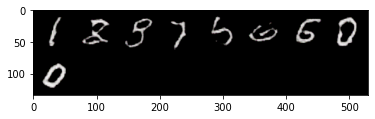

epoch :  19
G loss :  tensor(2.3837, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward>)
D loss :  tensor(0.4931, device='cuda:0', grad_fn=<AddBackward0>)



In [12]:
for epoch in range(epochs): 

    for i, batch in enumerate(data): 
        
        images, _ = batch
        images = images.to(device)
        
        # display batch grid    
        b_size = images.shape[0]
        label = torch.full((b_size, ), 1, device=device, dtype=torch.float32)
        ## training discriminator
        d_net.zero_grad()
        real_preds = d_net(images).view(-1)
        real_loss = bce_criterion(real_preds, label)
        real_loss.backward()
        
        noise = torch.randn((b_size, d_noise, 1, 1), device=device, dtype=torch.float32)
        label = label.fill_(0.0)
        # generate image 
        g_net.zero_grad()
        generated_images = g_net(noise)
        fake_preds = d_net(generated_images.detach()).view(-1)
        fake_loss = bce_criterion(fake_preds, label)
        fake_loss.backward()
        
        d_loss = fake_loss + real_loss
        d_optim.step()
        
        
        ## training generator
        label = label.fill_(1.)
        gen_preds = d_net(generated_images).view(-1)
        g_loss = bce_criterion(gen_preds, label)
        g_loss.backward()
        
        g_optim.step()
        
        if i % 50 == 0: 
            
            with torch.no_grad(): 
                z = torch.randn((9, 100, 1, 1), device=device, dtype=torch.float32)
                generated_images = g_net(z)
                display_grid(generated_images.cpu())
            print("epoch : ", epoch)
            print("G loss : ", g_loss) 
            print("D loss : ", d_loss)
            print()